# Multi-task Solution for Aspect Category Sentiment Analysis on Vietnamese Datasets

## 1. Một vài thông tin cơ bản
* Input: The text reviews in Vietnamese language.
* Output: 1 or N aspect and the corresponding sentiment
    * List of aspect: [SMELL, COLOUR, PACKING, SHIPPING, STAYINGPOWER, TEXTURE, PRICE, OTHERS]
    * List of sentiment: [Positive, Neutral, Negative]

**Example**:
* Input: Cây son có màu rất đẹp, còn rất lì nữa (The colour of the lipstick is beautiful, and it is very adhesive too)
* Output: COLOUR:Positive, STAYINGPOWER:Positive

## 2. Baselines
| Model                        | STL       |           | MTL       |           |
|------------------------------|-----------|-----------|-----------|-----------|
|                              | F1_ad (%) | F1_sc (%) | F1_ad (%) | F1_sc (%) |
| BiLSTM                       | 97.62     | 87.56     | 94.12     | 81.44     |
| BiGRU                        | 97.90     | 87.22     | 95.61     | 80.94     |
| BiLSTM + Conv1D              | 98.00     | 89.90     | 96.89     | 86.26     |
| BiGRU + Conv1D               | 98.09     | 91.01     | 97.51     | 86.92     |
| BiLSTM + BiGRU + Conv1D      | 97.92     | 90.15     | 96.63     | 85.65     |

## 3.Các khái niệm

### 3.1. STL (Single-Task Learning)
#### Định nghĩa
STL là phương pháp mà mỗi mô hình chỉ tập trung giải quyết một nhiệm vụ (task) duy nhất. Trong bài toán ABSA, các nhiệm vụ chính là:
* Phát hiện khía cạnh (Aspect Detection): Xác định xem bài đánh giá có đề cập đến các khía cạnh nào (ví dụ: giá cả, màu sắc, mùi hương, v.v.).
* Phân loại cảm xúc (Sentiment Classification): Với mỗi khía cạnh đã phát hiện, mô hình sẽ phân loại cảm xúc là tích cực, trung lập hay tiêu cực.
#### Triển khai
* Aspect Detection: Một mô hình đa nhãn (multi-label classification) để xác định xem bài đánh giá có chứa các khía cạnh nào.
* Sentiment Classification: Với mỗi khía cạnh, sẽ có một mô hình phân loại cảm xúc riêng biệt (ví dụ: mô hình cho màu sắc, mô hình cho giá cả, v.v.).
* Quy trình: Phát hiện khía cạnh trước, sau đó mới phân loại cảm xúc cho từng khía cạnh đã phát hiện. Nếu không phát hiện khía cạnh nào thì không phân loại cảm xúc cho khía cạnh đó.
### 3.2. MTL (Multi-Task Learning)
#### Định nghĩa
MTL là phương pháp huấn luyện một mô hình duy nhất để giải quyết đồng thời nhiều nhiệm vụ liên quan. Trong ABSA, mô hình sẽ cùng lúc phát hiện khía cạnh và phân loại cảm xúc cho từng khía cạnh đó.

#### Triển khai
* Shared Layers: Các lớp đầu vào và ẩn (hidden layers) được chia sẻ chung cho tất cả các nhiệm vụ.
* Task-specific Layers: Mỗi nhiệm vụ (phát hiện khía cạnh, phân loại cảm xúc cho từng khía cạnh) có các lớp đầu ra riêng.
* Quy trình: Mô hình đồng thời dự đoán khía cạnh và cảm xúc cho từng khía cạnh đó mà không cần chia thành hai bước riêng biệt.

### 3.3. Độ đo
#### F1_ad (F1-score for Aspect Detection):
Đây là độ đo F1-score được sử dụng để đánh giá khả năng phát hiện các khía cạnh (aspect) trong bài đánh giá. Mô hình sẽ xác định xem bài đánh giá có đề cập đến các khía cạnh nào (ví dụ: mùi hương, màu sắc, giá cả, v.v.). Công thức tính F1_ad:

$$\text{F1}_{ad} = 2 \times \frac{\text{Precision}_{ad} \times \text{Recall}_{ad}}{\text{Precision}_{ad} + \text{Recall}_{ad}}$$
Trong đó:

* $\text{Precision}_{ad}$: Độ chính xác phát hiện khía cạnh.
* $\text{Recall}_{ad}$: Độ phủ phát hiện khía cạnh.

#### F1_sc (F1-score for Sentiment Classification):
Đây là độ đo F1-score dùng để đánh giá khả năng phân loại cảm xúc (sentiment) cho từng khía cạnh đã được phát hiện (ví dụ: tích cực, trung lập, tiêu cực).Công thức tính F1_sc:

$$\text{F1}_{sc} = 2 \times \frac{\text{Precision}_{sc} \times \text{Recall}_{sc}}{\text{Precision}_{sc} + \text{Recall}_{sc}}$$

Trong đó:
* $\text{Precision}_{sc}$: Độ chính xác phân loại cảm xúc.
* $\text{Recall}_{sc}$: Độ phủ phân loại cảm xúc.

## 4. EDA

### Load dữ liệu

In [1]:
from os import path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mint.config import DATA_DIR

In [2]:
ViABSA_BP_dir = path.join(DATA_DIR, 'ViABSA_BP')

train_file = path.join(ViABSA_BP_dir, 'data_train.csv')
test_file = path.join(ViABSA_BP_dir, 'data_test.csv')
dev_file = path.join(ViABSA_BP_dir, 'data_dev.csv')

In [3]:
df = pd.read_csv(train_file)
df.head()

,data,stayingpower,texture,smell,price,others,colour,shipping,packing
0,"son đẹp lăm,sẽ ủng hộ tiếp , shipper cũng dễ t...",NaN,NaN,NaN,NaN,NaN,NaN,positive,NaN
1,Son đẹp lắm nha mn tuy là son nội địa giá rẻ n...,NaN,positive,positive,positive,NaN,NaN,NaN,NaN
2,"Son màu lên chuẩn, đẹp tuy nhiên dễ khô nên cầ...",NaN,negative,NaN,NaN,NaN,positive,NaN,NaN
3,Công dụng: rất đẹp\nKết cấu: tốt\nĐộ bền màu: ...,positive,positive,NaN,NaN,NaN,positive,NaN,NaN
4,"Hàng gói siêu chắc chắn, packing xinh xỉu, đủ ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,positive


### Thống kê cơ bản

In [4]:
print(df.head())
print("\nThông tin tổng quan:")
print(df.info())
print("\nThống kê mô tả:")
print(df.describe(include='all'))

                                                data stayingpower   texture  \
0  son đẹp lăm,sẽ ủng hộ tiếp , shipper cũng dễ t...          NaN       NaN   
1  Son đẹp lắm nha mn tuy là son nội địa giá rẻ n...          NaN  positive   
2  Son màu lên chuẩn, đẹp tuy nhiên dễ khô nên cầ...          NaN  negative   
3  Công dụng: rất đẹp\nKết cấu: tốt\nĐộ bền màu: ...     positive  positive   
4  Hàng gói siêu chắc chắn, packing xinh xỉu, đủ ...          NaN       NaN   

      smell     price others    colour  shipping   packing  
0       NaN       NaN    NaN       NaN  positive       NaN  
1  positive  positive    NaN       NaN       NaN       NaN  
2       NaN       NaN    NaN  positive       NaN       NaN  
3       NaN       NaN    NaN  positive       NaN       NaN  
4       NaN       NaN    NaN       NaN       NaN  positive  

Thông tin tổng quan:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12981 entries, 0 to 12980
Data columns (total 9 columns):
 #   Column        Non-Null C

### Phân phối các khía cạnh

In [5]:
aspects = ['stayingpower', 'texture', 'smell', 'price', 'others', 'colour', 'shipping', 'packing']

for aspect in aspects:
    df[aspect + '_exists'] = df[aspect].notna()

aspect_counts = df[[a + '_exists' for a in aspects]].sum()
aspect_counts.index = aspects

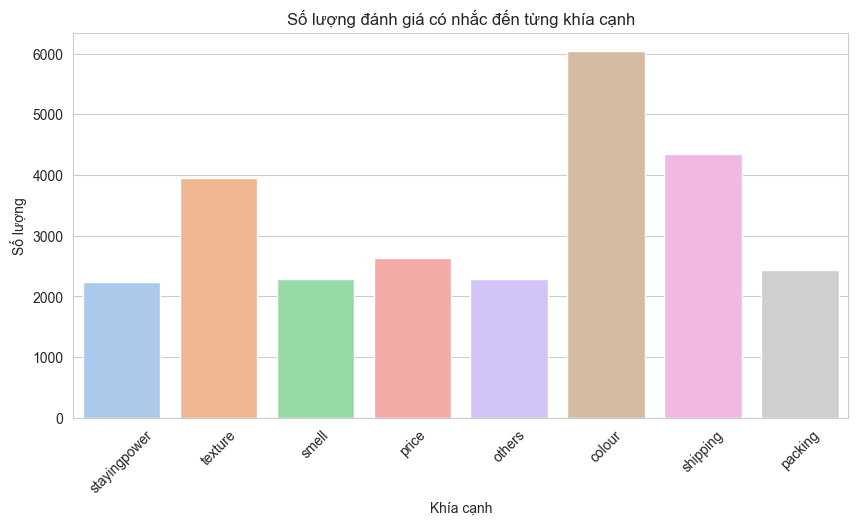

In [6]:
plt.figure(figsize=(10, 5))
sns.barplot(x=aspect_counts.index, y=aspect_counts.values, hue=aspect_counts.index, palette="pastel", legend=False)
plt.title("Số lượng đánh giá có nhắc đến từng khía cạnh")
plt.ylabel("Số lượng")
plt.xlabel("Khía cạnh")
plt.xticks(rotation=45)
plt.show()

### Phân bố cảm xúc theo từng khía cạnh

In [7]:
sentiment_aspects = {}

for aspect in aspects:
    sentiment_aspects[aspect] = df[aspect].value_counts()

# Chuẩn bị dữ liệu để vẽ biểu đồ
sentiment_df = pd.DataFrame()
for aspect in aspects:
    temp = df[aspect].value_counts().rename_axis('sentiment').reset_index(name='count')
    temp['aspect'] = aspect
    sentiment_df = pd.concat([sentiment_df, temp], ignore_index=True)
sentiment_df = sentiment_df.dropna()

25


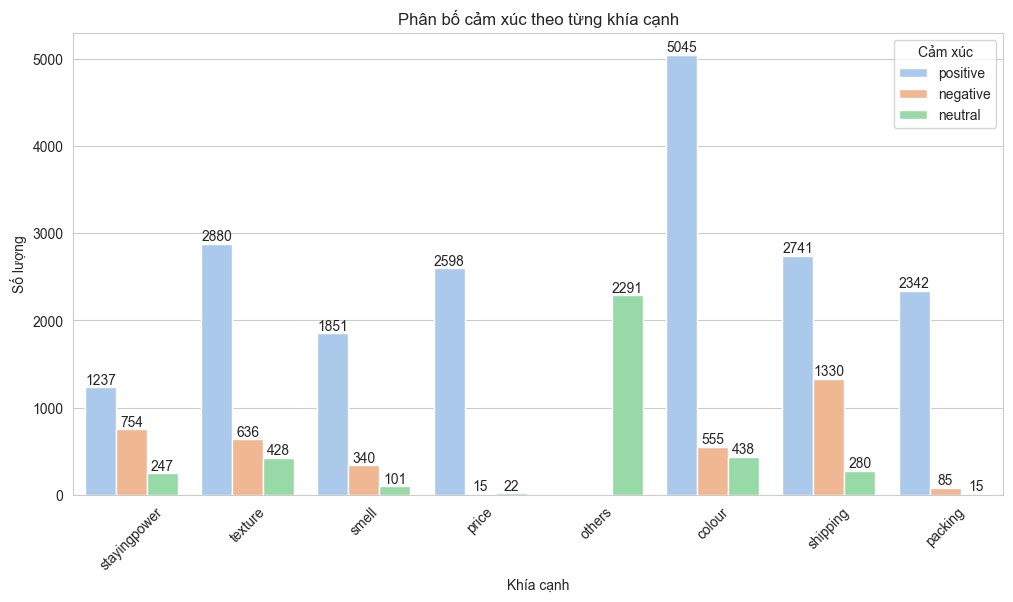

In [8]:
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='aspect', y='count', hue='sentiment', data=sentiment_df, palette="pastel")
plt.title("Phân bố cảm xúc theo từng khía cạnh")
plt.ylabel("Số lượng")
plt.xlabel("Khía cạnh")
plt.xticks(rotation=45)
plt.legend(title='Cảm xúc')

# Thêm text số lượng trên đầu các cây cột
for p in barplot.patches:
    height = p.get_height()
    if height <= 0:
        continue
    barplot.text(p.get_x() + p.get_width() / 2., height + 0.3, int(height), ha="center", va="bottom")


print(len(barplot.patches))
plt.show()

### Phân bố số lượng khía cạnh trong mỗi đánh giá

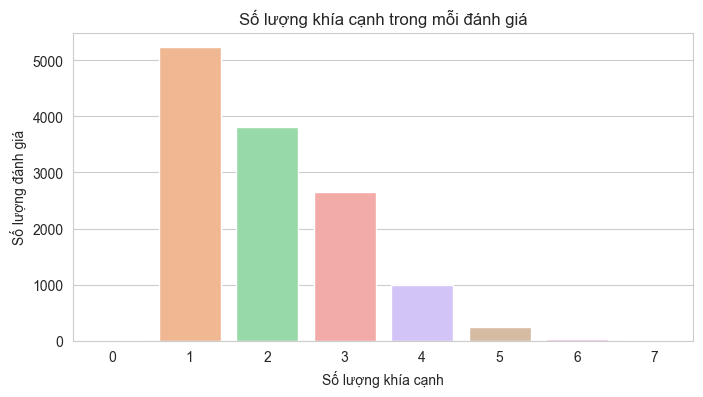

In [9]:
df['num_aspects'] = df[[a + '_exists' for a in aspects]].sum(axis=1)

plt.figure(figsize=(8, 4))
sns.countplot(x='num_aspects', hue='num_aspects', data=df, palette="pastel", legend=False)
plt.title("Số lượng khía cạnh trong mỗi đánh giá")
plt.xlabel("Số lượng khía cạnh")
plt.ylabel("Số lượng đánh giá")
plt.show()